# Focus Area 2 — Next-Gen Precipitation for Trends & Extremes
**Core Objective**: To compare next-generation precipitation datasets for historical trends,
anomalies, and extreme event performance, enabling NMHS to select optimal products for
climate monitoring and risk assessment.

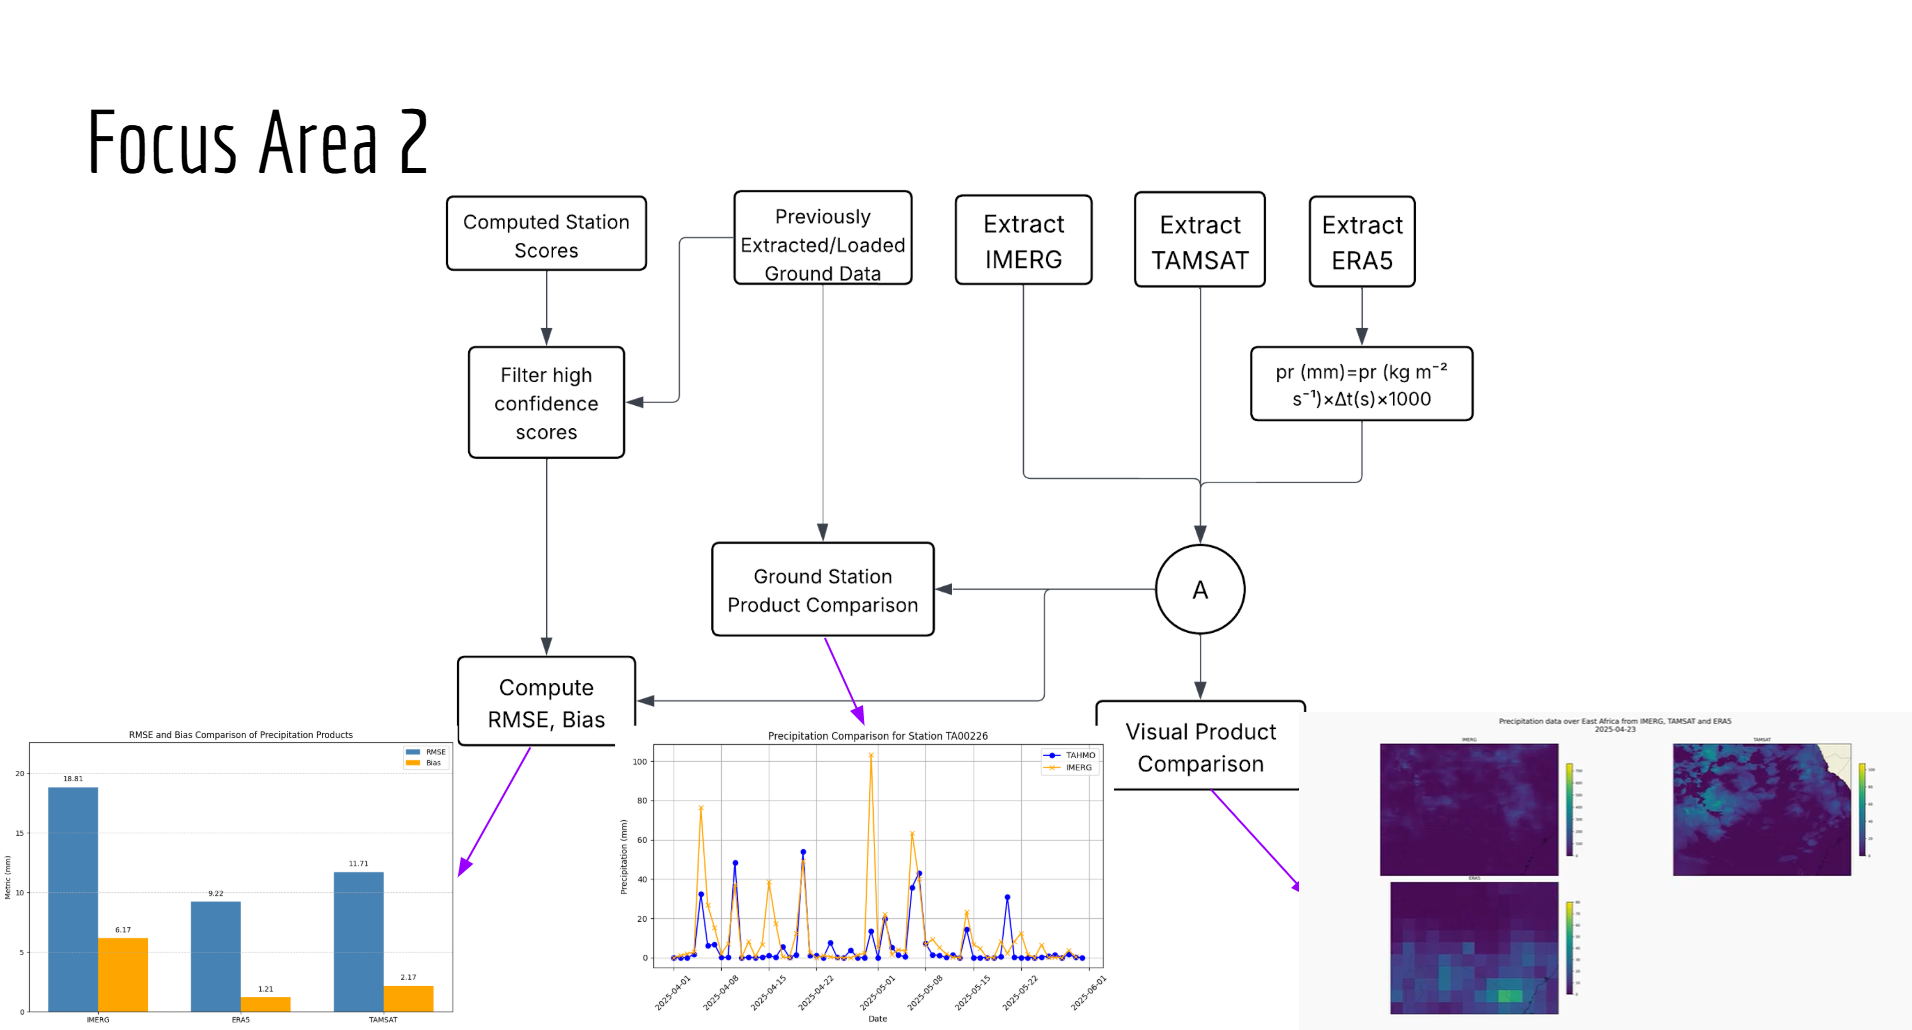

Require 2 files
- The Metadata file: TAHMO_Metadata.csv
- The TAHMO data file: TAHMO_data.csv

Metadata file format (Columns):
<!DOCTYPE html>
<html>
<head>
    <title>TAHMO Metadata</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Code</th>
            <th>lat</th>
            <th>lon</th>
        </tr>
        <tr>
            <td>TA00283</td>
            <td>1.2345</td>
            <td>36.7890</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Data file format (Columns): Temperature / Precipitation data for multiple stations
<html>
<head>
    <title>TAHMO Data</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Date</th>
            <th>TA00283</th>
            <th>TA00284</th>
            <th>TA00285</th>
            <!-- More station codes as needed -->
        </tr>
        <tr>
            <td>2023-01-01</td>
            <td>25.3</td>
            <td>26.1</td>
            <td>24.8</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Steps Breakdown
- Step 1: Setting up environment and Authentication

- Data Extraction and Loading
    - Step2: Search and Select Region of Interest please use the same region as you did in the previous focus area
    - Step 3: Extract TAMSAT data
    - Step 4: Extract IMERG data
    - Step 5: Extract ERA5 data

- Data Processing and QC

    - Step 6: Load ERA5, TAMSAT, IMERG abd TAHMO/Custom data
    - Step 7: Plot the datasets
    - Step 8: Build Point comparison with the satellite and reanalysis dataset
    - Step 9: Load the station scores and filter the high confidence stations as in Focus 1
    - Step 10: Compute RMSE and Bias for ERA5, TAMSAT, IMERG
    - Step 11: Visualise the products performance

For any questions or concerns reach out please send an email to kaburiaaustin1@tahmo.org

In [1]:
# @title Step 1a: Setting up environment installing required Dependencies
# @markdown This cell installs the required dependencies for the workshop. It may take a few minutes <br>
# @markdown If you encounter any errors, please restart the runtime and try again. <br>
# @markdown If the error persists, please seek help.


print("Installing required dependencies...")
!pip install git+https://github.com/kaburia/NOAA-workshop.git > /dev/null 2>&1

!jupyter nbextension enable --py widgetsnbextension

# check there was no error
import sys
if not sys.argv[0].endswith("kernel_launcher.py"):
    print("❌ Errors occurred during installation. Please restart the runtime and try again.")
else:
    print("✅ Dependencies installed successfully.")

print("Importing required libraries...")
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr
import numpy as np
from scipy.stats import pearsonr, ttest_rel

# import os
# os.chdir('NOAA-workshop')

from utils.ground_stations import plot_stations_folium
from utils.helpers import get_region_geojson
from utils.CHIRPS_helpers import get_chirps_pentad_gee
from utils.plotting import plot_xarray_data, plot_xarray_data2, compare_xarray_datasets2
from utils.IMERG_helpers import get_imerg_raw
from utils.ERA5_helpers import era5_data_extracts, era5_var_handling
from google.colab import drive

%matplotlib inline

print("✅ Libraries imported successfully.")

def build_xr_from_stations(ds, stations_metadata, var_name=None):
    # Auto-detect variable if not provided
    if var_name is None:
        candidate_vars = ['total_precipitation', 'total_rainfall', 'precipitation']
        found = [v for v in candidate_vars if v in ds.data_vars]
        if not found:
            raise ValueError(f"None of expected precipitation variable names {candidate_vars} found in dataset vars: {list(ds.data_vars)}")
        var_name = found[0]

    # Determine dimension names
    if {'x', 'y'}.issubset(ds.dims):
        lon_dim, lat_dim = 'x', 'y'
    elif {'lon', 'lat'}.issubset(ds.dims):
        lon_dim, lat_dim = 'lon', 'lat'
    else:
        raise ValueError(f"Dataset dims {list(ds.dims)} do not contain expected (x,y) or (lon,lat).")

    all_stations_data = {}
    for _, row in stations_metadata.iterrows():
        station_code = row['code']
        lat = float(row['lat'])
        lon = float(row['lon'])
        # Skip stations outside domain (quick bounds check)
        if not (ds[lon_dim].min() <= lon <= ds[lon_dim].max() and ds[lat_dim].min() <= lat <= ds[lat_dim].max()):
            continue
        station_da = ds[var_name].sel({lon_dim: lon, lat_dim: lat}, method="nearest")
        station_df = station_da.to_dataframe(name=station_code)
        all_stations_data[station_code] = station_df[station_code]

    combined_df = pd.DataFrame(all_stations_data)
    return combined_df

Installing required dependencies...
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
✅ Dependencies installed successfully.
Importing required libraries...
✅ Libraries imported successfully.


In [2]:
# @title ### Step 1b: Authentication Step
# @markdown This step is used to authenticate you as a user and there will be two popups that will be doing this.
# @markdown 1. **Authentication to Google Drive** - This is where we shall be loading the data after we have extracted it
# @markdown 2. **Authentication to Google Earth Engine** - This will be used to extract the CHIRPS data and any other satellite product we shall be extracting in the future.
# @markdown Please check your email we shared an invitation to our Google Cloud Project that we shall be using to extract the data
# @markdown *PS: In the future, to create your own project, please refer to [Google Cloud's Documentation](https://developers.google.com/earth-engine/guides/access) that shows the step by step breakdown of creating a Google Cloud Project and enabling Google Earth Engine*
# @markdown  Link to configure noncommercial use of Google Earth Engine: https://console.cloud.google.com/earth-engine/configuration

print("Authenticating to Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive authenticated successfully.")

print("Authenticating to Google Earth Engine...")
ee.Authenticate()
ee.Initialize(project='noaa-tahmo')
print("✅ Google Earth Engine authenticated successfully.")

Authenticating to Google Drive...
Mounted at /content/drive
✅ Google Drive authenticated successfully.
Authenticating to Google Earth Engine...
✅ Google Earth Engine authenticated successfully.



A config file is provided with the api keys to access TAHMO Data
```json
{
    "apiKey": "",
    "apiSecret": "",
    "location_keys": ""

}


In [3]:
# @title Step 1c: Please upload the provided config file
from google.colab import files
uploaded = files.upload()

Saving config.json to config (1).json


In [6]:
# @title Step 2: Search and Select Region of Interest please use the same region as you did in the previous focus area
# @markdown Enter the name of a country, region, or place in Africa. <br>
# @markdown The Google Maps API will be used to fetch its geometry, bounding box, and show the polygon on a map.<br>
# @markdown We highly recommend to use a region within the East Africa for everything to run smoothly

import json
import folium

# print("Loading config file...")
# Load config file
# Load API key
with open('/content/config.json', 'r') as f:
    config = json.load(f)

location_key = config['location_keys']  # Google Maps API key

# --- Helper functions ---
def xmin_ymin_xmax_ymax(polygon):
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]
    return min(lons), min(lats), max(lons), max(lats)

def fetch_region(query):
    region_geom = get_region_geojson(query, location_key)['geometry']['coordinates'][0]
    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
    print(f"✅ Selected: {query}")
    print(f"Bounding box -> xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
    return region_geom, (xmin, ymin, xmax, ymax)

def show_region_polygon(polygon):
    # Center map on polygon
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]
    m = folium.Map(location=[sum(lats)/len(lats), sum(lons)/len(lons)], zoom_start=6)
    folium.Polygon(
        locations=[(lat, lon) for lon, lat in polygon],
        color="blue",
        weight=2,
        fill=True,
        fill_opacity=0.3,
    ).add_to(m)
    return m

# --- Main logic ---
region_query = input("🌍 Enter the name of a region (e.g. Kenya, Uganda, Serengeti): ")

try:
    region_geom, bbox = fetch_region(region_query)
    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
    m = show_region_polygon(region_geom)  # draw polygon, not bbox
    display(m)
except Exception as e:
    print(f"❌ Could not fetch geometry for '{region_query}': {e}")
    print("🔁 Please re-run the cell and enter a different region.")


start_date = "2025-04-01"
end_date = "2025-05-31"

dir_path = '/content/drive/MyDrive/NOAA-workshop-data'
os.makedirs(dir_path, exist_ok=True)
# check if the path was created successfully
if not os.path.exists(dir_path):
    print("❌ Path not created successfully.")
else:
    print("✅ Path created successfully.")

🌍 Enter the name of a region (e.g. Kenya, Uganda, Serengeti): Kenya
✅ Selected: Kenya
Bounding box -> xmin: 33.90982109999999, ymin: -4.724299999999999, xmax: 41.90684160000001, ymax: 5.033420899999999


✅ Path created successfully.


## Data Extraction and Loading
1. Satellite/model daily precip NetCDFs: TAMSAT, GPM/IMERG, ERA5, CBAM → precip (mm/day)
2. Extract GHCNd Data
3. Load TAHMO data previously extracted in session 1

### Extract TAMSAT Data (Satellite Product)

In [18]:
# @title Step 3:  Extracing TAMSAT data
# @markdown The process begins by setting up the environment to access the API created to access the data <br>
# @markdown The next step is extracting the data from the endpoint<br>
# @markdown And finally to extract the region of interest<br>
# @markdown Data extraction takes approximately 5 minutes to run

!git clone https://github.com/TAMSAT/tamsat_download_extraction_api

file_path = "tamsat_download_extraction_api/tamsat_download_extract_api.py"

# Read the file
with open(file_path, "r") as file:
    content = file.read()

# Replace np.float with np.float64
content = content.replace("np.float", "np.float64")

# Write back the modified content
with open(file_path, "w") as file:
    file.write(content)

print("Successfully replaced np.float with np.float64.")

import sys
sys.path.append('tamsat_download_extraction_api')

from tamsat_download_extract_api import download, extract
import shutil

# sys.path.append('utils/tamsat_download_extraction_api/tamsat_download_extract_api.py')

# from utils.tamsat_download_extraction_api import download, extract
curr_dir = os.getcwd()

print(f'Beginning TAMSAT data extraction for {region_query}')

# Download data
download({
    "timestep": 'daily' ,
    "resolution": 0.0375,
    "start_date": start_date,
    "end_date": end_date,
    "version": 3.1,
    "localdata_dir": '/home/user/scripts/tamsat_api/data'
    })

# check if the file exists
if not os.path.exists('/home/user/scripts/tamsat_api/data'):
  print('❌ Errors occurred during extraction. Please restart the runtime and try again.')
else:
  print('✅ TAMSAT data extraction completed successfully.')


extract({
    "extract_type": 'domain',
    "S": ymin,
    "N": ymax,
    "W": xmin,
    "E": xmax,
    "timestep": 'daily',
    "start_date": start_date,
    "end_date": end_date,
    "version": 3.1,
    "localdata_dir": '/home/user/scripts/tamsat_api/data',
    "resolution": 0.0375
})

# save to drive
file_path = f'/home/user/scripts/tamsat_api/data/extracted_data/domain/TAMSATv3.1_daily_0.0375_{ymax}_{ymin}_{xmin}_{xmax}_{start_date}_{end_date}.nc'

# rename file path to TAMSAT_precip_{region_query}.nc
shutil.move(file_path, f'{dir_path}/TAMSAT_precip_{region_query}.nc')

# copy to drive with the same name but under the NOAA-workshop-data with tehregion_query name

fatal: destination path 'tamsat_download_extraction_api' already exists and is not an empty directory.
Successfully replaced np.float with np.float64.
Beginning TAMSAT data extraction for Kenya
✅ TAMSAT data extraction completed successfully.
Extracting domain TAMSAT rainfall estimates for N: 5.033420899999999, S: -4.724299999999999, W: 33.90982109999999 and E: 41.90684160000001
Created file: /home/user/scripts/tamsat_api/data/extracted_data/domain/TAMSATv3.1_daily_0.0375_5.033420899999999_-4.724299999999999_33.90982109999999_41.90684160000001_2025-04-01_2025-05-31.nc


'/content/drive/MyDrive/NOAA-workshop-data/TAMSAT_precip_Kenya.nc'

In [19]:
!pwd

/home/user/scripts/tamsat_api/data/tamsat/rfe/data/v3.1/daily/2025/05


In [8]:
# @title Step 4:  Extract IMERG Data (Satellite Product)
# @markdown Data is extracted for the region selected
# @markdown This code takes a long time to run ~90mins, It aims to show how to extract IMERG data but for this workshop we have extracted the data for you
#
# Define region of interest (KE,RW, UG)
roi = ee.Geometry.Polygon(region_geom)

# # Raw 30-min IMERG rainfall (mm/hr)
# ds_raw = get_imerg_raw(start_date,
#                         end_date,
#                        region=roi,
#                        export_path=f'{dir_path}/imerg_{region_query}.nc')


In [9]:
# @title Step 5: Extract ERA5 (Reanalysis Product)
# @markdown Data extracted is then saved to your drive to be loaded later <br>
# @markdown The extraction process takes approximately 5 minutes to run

# ERA5 helper expects ISO-like datetime strings with time component (%Y-%m-%dT%H:%M:%S)
iso_start_date = f"{start_date}T00:00:00"
iso_end_date = f"{end_date}T23:59:59"

era5_eac_data = era5_data_extracts(iso_start_date, iso_end_date, era5_l=False,
                                   polygon=region_geom)

# te_ds_era5_ke = era5_var_handling(era5_ke_data, 'temperature_2m', xarray_ds=True)
eac_pr_ds_era5 = era5_var_handling(era5_eac_data, 'total_precipitation', xarray_ds=True)

# save to xarray
eac_pr_ds_era5.to_netcdf(f'{dir_path}/ERA5_precip_{region_query}.nc')


# plot_xarray_data2(
#     xarray_ds=eac_pr_ds_era5,
#     fig_title="ERA5 Precipitation Analysis in East Africa",
#     columns=["total_precipitation"],
#     plot_size=7,
#     bbox=[xmin, ymin, xmax, ymax],
# )



Processing 2025-04-01T00:00:00 to 2025-04-02T00:00:00
Processing 2025-04-02T00:00:00 to 2025-04-03T00:00:00
Processing 2025-04-03T00:00:00 to 2025-04-04T00:00:00
Processing 2025-04-04T00:00:00 to 2025-04-05T00:00:00
Processing 2025-04-05T00:00:00 to 2025-04-06T00:00:00
Processing 2025-04-06T00:00:00 to 2025-04-07T00:00:00
Processing 2025-04-07T00:00:00 to 2025-04-08T00:00:00
Processing 2025-04-08T00:00:00 to 2025-04-09T00:00:00
Processing 2025-04-09T00:00:00 to 2025-04-10T00:00:00
Processing 2025-04-10T00:00:00 to 2025-04-11T00:00:00
Processing 2025-04-11T00:00:00 to 2025-04-12T00:00:00
Processing 2025-04-12T00:00:00 to 2025-04-13T00:00:00
Processing 2025-04-13T00:00:00 to 2025-04-14T00:00:00
Processing 2025-04-14T00:00:00 to 2025-04-15T00:00:00
Processing 2025-04-15T00:00:00 to 2025-04-16T00:00:00
Processing 2025-04-16T00:00:00 to 2025-04-17T00:00:00
Processing 2025-04-17T00:00:00 to 2025-04-18T00:00:00
Processing 2025-04-18T00:00:00 to 2025-04-19T00:00:00
Processing 2025-04-19T00:00:

### Load the extracted datasets for April-May 2025
- TAHMO (can be replaced with your dataset)
- ERA5
- TAMSAT
- IMERG

In [11]:
# @title Step 6a: Load the TAHMO/Your previously uploaded data
# metadata
tahmo_metadata = pd.read_csv(f'{dir_path}/tahmo_metadata_{region_query}.csv')
tahmo_metadata = tahmo_metadata[['code', 'location.latitude', 'location.longitude']].rename(columns={'location.latitude': 'lat',
                                                                                                 'location.longitude': 'lon'})


tahmo_pr = pd.read_csv(f'{dir_path}/tahmo_precip_{region_query}.csv')
tahmo_pr = tahmo_pr.rename(columns={"Unnamed: 0": "Date"})
tahmo_pr['Date'] = pd.to_datetime(tahmo_pr['Date'])
tahmo_pr = tahmo_pr.set_index('Date')
tahmo_pr.index = tahmo_pr.index.tz_localize(None)

# Drop stations with multiple sensors station_sensor columns
multiple_sensors = [i for i in tahmo_pr.columns if len(i.split('_')) > 1]
tahmo_pr = tahmo_pr.drop(columns=multiple_sensors)

tahmo_pr

,TA00001,TA00018,TA00019,TA00020,TA00021,TA00022,TA00023,TA00024,TA00026,TA00027,...,TA00876,TA00879,TA00880,TA00884,TA00907,TA00909,TD00001,TD00002,TD00004,TD00005
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-01,0.000,0.204,0.748,0.051,0.068,NaN,NaN,0.068,6.871,NaN,...,0.034,0.000,2.058,0.000,NaN,NaN,19.77,0.00,0.00,NaN
2025-04-02,0.068,0.187,0.051,0.017,0.017,NaN,NaN,0.034,0.238,NaN,...,0.136,0.000,0.000,0.000,NaN,NaN,0.00,0.00,0.00,NaN
2025-04-03,0.000,0.153,0.000,1.343,0.000,NaN,NaN,0.749,1.836,NaN,...,2.395,26.473,26.300,0.187,NaN,NaN,0.00,1.03,0.53,NaN
2025-04-04,18.485,0.136,2.839,0.833,8.450,NaN,NaN,6.446,8.778,NaN,...,6.925,2.140,0.000,0.000,NaN,NaN,0.05,0.01,1.65,NaN
2025-04-05,3.198,0.136,0.595,0.255,0.391,NaN,NaN,0.000,0.272,NaN,...,7.225,5.546,15.214,11.029,NaN,NaN,1.38,7.35,14.30,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27,0.544,4.066,0.289,0.136,7.150,NaN,NaN,NaN,22.605,NaN,...,0.153,8.893,NaN,0.000,NaN,NaN,2.17,NaN,3.70,NaN
2025-05-28,0.221,5.460,0.187,0.000,0.119,NaN,NaN,NaN,0.119,NaN,...,9.216,0.000,NaN,0.017,NaN,NaN,0.52,NaN,0.66,NaN
2025-05-29,0.187,3.472,0.102,0.000,0.493,NaN,NaN,NaN,4.219,NaN,...,5.170,1.139,NaN,0.000,NaN,NaN,2.45,NaN,1.00,NaN


In [12]:
# @title Step 6b: Loading the extracted ERA5 data
# ERA5
era5_pr = xr.open_dataset(f'{dir_path}/ERA5_precip_{region_query}.nc')
era5_pr

# rename lat, lon to x,y
era5_pr = era5_pr.rename({'lat': 'y', 'lon': 'x'})
era5_pr

<xarray.Dataset> Size: 49kB
Dimensions:              (y: 11, x: 9, time: 61)
Coordinates:
  * y                    (y) float64 88B -4.5 -3.5 -2.5 -1.5 ... 2.5 3.5 4.5 5.5
  * x                    (x) float64 72B 33.5 34.5 35.5 36.5 ... 39.5 40.5 41.5
  * time                 (time) datetime64[ns] 488B 2025-04-01 ... 2025-05-31
Data variables:
    total_precipitation  (time, y, x) float64 48kB ...

In [39]:
# @title Step 6c: Loading IMERG data
# IMERG
imerg_pr = xr.open_dataset('/content/drive/Shareddrives/NOAA-workshop/Datasets/satellite/imerg_april_may2025.nc')

# Aggregate by computing the daily sum
imerg_pr = imerg_pr.resample(time='D').sum()

# precipitation_values = imerg_pr['precipitation'].values.flatten()
# precipitation_values = precipitation_values[~np.isnan(precipitation_values)]
# largest_10_indices = np.argsort(precipitation_values)[-50:]
# largest_10_values = precipitation_values[largest_10_indices]

# print("Largest 10 precipitation values:")
# display(largest_10_values)

# Filter the IMERG dataset based on the bounding box
imerg_pr = imerg_pr.sel(
    x=slice(xmin, xmax),
    y=slice(ymax, ymin)
)

# Save the filtered data
# imerg_pr_filtered.to_netcdf(f'{dir_path}/imerg_filtered_{region_query}.nc')

# You can optionally display the filtered data to check
# display(imerg_pr_filtered)
imerg_pr

<xarray.Dataset> Size: 2MB
Dimensions:        (time: 60, y: 108, x: 89)
Coordinates:
  * x              (x) float64 712B 33.93 34.02 34.11 34.2 ... 41.66 41.75 41.84
  * y              (y) float64 864B 4.974 4.885 4.795 ... -4.458 -4.548 -4.638
  * time           (time) datetime64[ns] 480B 2025-04-01 ... 2025-05-30
Data variables:
    precipitation  (time, y, x) float32 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.71
    spatial_ref    (time) int64 480B 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [26]:
imerg_pr.x

<xarray.DataArray 'x' (x: 146)> Size: 1kB
array([28.903219, 28.993051, 29.082882, 29.172714, 29.262545, 29.352377,
       29.442208, 29.53204 , 29.621872, 29.711703, 29.801535, 29.891366,
       29.981198, 30.071029, 30.160861, 30.250692, 30.340524, 30.430355,
       30.520187, 30.610018, 30.69985 , 30.789681, 30.879513, 30.969344,
       31.059176, 31.149008, 31.238839, 31.328671, 31.418502, 31.508334,
       31.598165, 31.687997, 31.777828, 31.86766 , 31.957491, 32.047323,
       32.137154, 32.226986, 32.316817, 32.406649, 32.49648 , 32.586312,
       32.676144, 32.765975, 32.855807, 32.945638, 33.03547 , 33.125301,
       33.215133, 33.304964, 33.394796, 33.484627, 33.574459, 33.66429 ,
       33.754122, 33.843953, 33.933785, 34.023616, 34.113448, 34.203279,
       34.293111, 34.382943, 34.472774, 34.562606, 34.652437, 34.742269,
       34.8321  , 34.921932, 35.011763, 35.101595, 35.191426, 35.281258,
       35.371089, 35.460921, 35.550752, 35.640584, 35.730415, 35.820247,
       35.910079, 35.99991 , 36.089742, 36.179573, 36.269405, 36.359236,
       36.449068, 36.538899, 36.628731, 36.718562, 36.808394, 36.898225,
       36.988057, 37.077888, 37.16772 , 37.257551, 37.347383, 37.437215,
       37.527046, 37.616878, 37.706709, 37.796541, 37.886372, 37.976204,
       38.066035, 38.155867, 38.245698, 38.33553 , 38.425361, 38.515193,
       38.605024, 38.694856, 38.784687, 38.874519, 38.964351, 39.054182,
       39.144014, 39.233845, 39.323677, 39.413508, 39.50334 , 39.593171,
       39.683003, 39.772834, 39.862666, 39.952497, 40.042329, 40.13216 ,
       40.221992, 40.311823, 40.401655, 40.491486, 40.581318, 40.67115 ,
       40.760981, 40.850813, 40.940644, 41.030476, 41.120307, 41.210139,
       41.29997 , 41.389802, 41.479633, 41.569465, 41.659296, 41.749128,
       41.838959, 41.928791])
Coordinates:
  * x        (x) float64 1kB 28.9 28.99 29.08 29.17 ... 41.66 41.75 41.84 41.93

In [20]:
# @title Step 6d: Loading extracted TAMSAT data
# TAMSAT
tamsat_pr = xr.open_dataset(f'{dir_path}/TAMSAT_precip_{region_query}.nc')

# rename lat lon to x y
tamsat_pr = tamsat_pr.rename({'lat': 'y', 'lon': 'x'})
tamsat_pr

<xarray.Dataset> Size: 27MB
Dimensions:     (time: 61, y: 260, x: 213)
Coordinates:
  * x           (x) float64 2kB 33.94 33.97 34.01 34.05 ... 41.81 41.85 41.89
  * y           (y) float64 2kB 5.025 4.987 4.95 4.913 ... -4.612 -4.65 -4.688
  * time        (time) datetime64[ns] 488B 2025-04-01 2025-04-02 ... 2025-05-31
Data variables:
    rfe         (time, y, x) float32 14MB ...
    rfe_filled  (time, y, x) float32 14MB ...
Attributes:
    title:            TAMSAT Rainfall Estimate (RFE) - Version 3.1
    institution:      TAMSAT Research Group, Meteorology Department, Universi...
    contact:          tamsat@reading.ac.uk
    Conventions:      CF-1.7
    estimate_filled:  False
    history:          Processed from TIR archive using satop with max_gap[min...
    latmin:           -35.9625
    latmax:           38.025
    lonmin:           -19.0125
    lonmax:           51.975
    latres:           0.0375
    lonres:           0.0375

In [ ]:
# @title Step 7: Plot the datasets
# @markdown - IMERG
# @markdown - TAMSAT
# @markdown - ERA5
datasets = [
    imerg_pr['precipitation'].to_dataset(name='IMERG'),
    tamsat_pr['rfe_filled'].to_dataset(name='TAMSAT'),
    era5_pr['total_precipitation'].to_dataset(name='ERA5')
]

labels = [
    'IMERG',
    'TAMSAT',
    'ERA5'
]
bboxes = [
    [xmin, ymin, xmax, ymax],
    [xmin, ymin, xmax, ymax],
    [xmin, ymin, xmax, ymax]
]

compare_xarray_datasets2(
    datasets,
    labels,
    fig_title=f'Precipitation data over {region_query} from IMERG, TAMSAT and ERA5',
    bboxes=bboxes,
    plot_size=5,
    save=True
)

## Data Processing
1. Build country-wide LTN (e.g., 2014–2025) and anomalies.
2. Compare skill of multiple rainfall products against ground for events vs climatology.

3. Only use Ground stations with high confidence as determined in Focus area 1
4. Rank products by RMSE, bias, correlation; articulate operational pros/cons.
5. (New) Add significance tests for trends and visualize spatial biases.

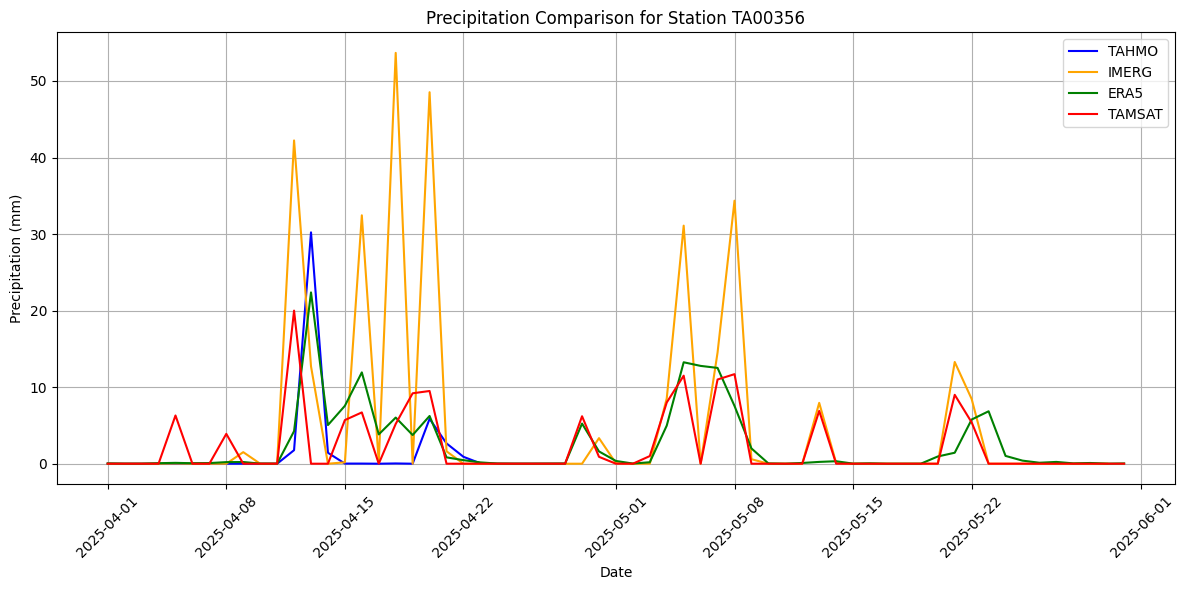

In [34]:
# @title Step 8: Build Point comparison with the satellite and reanalysis dataset
# Redefine with flexible dim handling (original assumed x/y; ERA5 uses lat/lon)
def build_xr_from_stations(ds, stations_metadata, var_name = 'total_precipitation'):

        # Determine dimension names
        if {'x', 'y'}.issubset(ds.dims):
                lon_dim, lat_dim = 'x', 'y'
        elif {'lon', 'lat'}.issubset(ds.dims):
                lon_dim, lat_dim = 'lon', 'lat'
        else:
                raise ValueError(f"Dataset dims {list(ds.dims)} do not contain expected (x,y) or (lon,lat).")

        all_stations_data = {}
        for _, row in stations_metadata.iterrows():
                station_code = row['code']
                lat = row['lat']
                lon = row['lon']
                try:
                        station_da = ds[var_name].sel({lon_dim: lon, lat_dim: lat}, method="nearest")
                        station_df = station_da.to_dataframe(name=station_code)
                        all_stations_data[station_code] = station_df[station_code]
                except KeyError:
                        # Skip if variable not present
                        continue

        combined_df = pd.DataFrame(all_stations_data)
        # Align index to daily range if needed (optional)
        return combined_df


imerg_ground = build_xr_from_stations(imerg_pr, tahmo_metadata, var_name='precipitation')
era5_ground = build_xr_from_stations(era5_pr, tahmo_metadata, var_name='total_precipitation')
tamsat_ground = build_xr_from_stations(tamsat_pr, tahmo_metadata, var_name='rfe_filled')


def plot_xr_vs_ground_single_station(tahmo_data, imerg_data, era5_data, tamsat_data, station_code):
    plt.figure(figsize=(12, 6))
    plt.plot(tahmo_data.index, tahmo_data.values, label='TAHMO', color='blue')
    plt.plot(imerg_data.index, imerg_data.values, label='IMERG', color='orange')
    plt.plot(era5_data.index, era5_data.values, label='ERA5', color='green')
    plt.plot(tamsat_data.index, tamsat_data.values, label='TAMSAT', color='red')

    plt.title(f'Precipitation Comparison for Station {station_code}')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Select a random station common to all datasets
common_stations = tahmo_pr.columns.intersection(imerg_ground.columns).intersection(era5_ground.columns).intersection(tamsat_ground.columns).tolist()

import random
if common_stations:
    random_station = random.choice(common_stations)
    plot_xr_vs_ground_single_station(tahmo_pr[random_station], imerg_ground[random_station], era5_ground[random_station], tamsat_ground[random_station], random_station)
else:
    print("No stations common to all datasets found.")

In [36]:
# @title Step 9: Load the station scores and filter the high confidence stations as in Focus 1
# @markdown The assumption made is that the stations with high confidence score (>70%) are clean stations and can be used to evaluate the other prducts
def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.nanmean((a-b)**2)))

# compute station scores
def compute_station_scores(eac_pentad, chirps_stations): # returns a dataframe of scores 'station_id','confidence_score','pearson_r','rmse','bias_signif'
    # get the union stations
    stations = eac_pentad.columns.intersection(chirps_stations.columns)
    scores = []
    for station in stations:
        obs = eac_pentad[station]
        sim = chirps_stations[station]

        # Compute metrics
        r, _ = pearsonr(obs, sim)
        error = rmse(obs, sim)
        t_stat, p_val = ttest_rel(obs, sim)
        bias_signif = 'Significant' if p_val < 0.05 else 'Not Significant'
        completeness = 1 - obs.isna().mean()
        outlier_rate = (obs < 0).mean()
        confidence_score = 100 * (0.4 * completeness + 0.4 * np.nan_to_num(r, nan=0) + 0.2 * (1 - outlier_rate))
        scores.append(
            {
                'station_id': station,
                'confidence_score': confidence_score,
                'pearson_r': r,
                'rmse': error,
                'bias_signif': bias_signif,
                'completeness': completeness,
                'outlier_rate': outlier_rate
            }
        )
    scores_df = pd.DataFrame(scores)
    return scores_df

station_scores_imerg = compute_station_scores(tahmo_pr.iloc[:-1], imerg_ground)
station_scores_era5 = compute_station_scores(tahmo_pr, era5_ground)
station_scores_tamsat = compute_station_scores(tahmo_pr, tamsat_ground)


 # Load the stations with confidence scores
stations_scores_chirps = pd.read_csv(f'{dir_path}/station_scores_{region_query}.csv')

 # filter to high confidence scores for chirps as in section 1
stations_scores_chirps_high = stations_scores_chirps[stations_scores_chirps['confidence_score'] > 70].sort_values(by='confidence_score')
high_conf_stations = stations_scores_chirps_high.station_id.tolist()

# for the imerg, tamsat and era5 drop any other station not in high_conf_stations
station_scores_imerg = station_scores_imerg[station_scores_imerg['station_id'].isin(high_conf_stations)]
station_scores_era5 = station_scores_era5[station_scores_era5['station_id'].isin(high_conf_stations)]
station_scores_tamsat = station_scores_tamsat[station_scores_tamsat['station_id'].isin(high_conf_stations)]

tahmo_pr_high_conf = tahmo_pr[high_conf_stations]
imerg_ground_high_conf = imerg_ground[high_conf_stations]
era5_ground_high_conf = era5_ground[high_conf_stations]
tamsat_ground_high_conf = tamsat_ground[high_conf_stations]

In [37]:
# @title Step 10: Compute RMSE and Bias for ERA5, TAMSAT, IMERG

import numpy as np
import pandas as pd

def compute_metric(df_x, df_y, metric="rmse", axis=0, skipna=True):
    """
    Compute RMSE or Bias between two aligned DataFrames.

    Args:
        df_x (pd.DataFrame): Observed or reference data.
        df_y (pd.DataFrame): Predicted or comparison data.
        metric (str): 'rmse' or 'bias'.
        axis (int): 0 = per column (station-level),
                    None = global metric across all values.
        skipna (bool): If True, ignore NaN values.

    Returns:
        pd.Series (if axis=0) or float (if axis=None).
    """
    if df_x.shape != df_y.shape:
        raise ValueError("DataFrames must have the same shape")

    diff = df_y - df_x

    if skipna:
        nanmean = np.nanmean
    else:
        nanmean = np.mean

    if metric.lower() == "rmse":
        if axis is None:  # global
            return float(np.sqrt(nanmean(diff.values**2)))
        else:  # per column
            return np.sqrt((diff**2).mean(axis=axis, skipna=skipna))
    elif metric.lower() == "bias":
        if axis is None:  # global
            return float(nanmean(diff.values))
        else:  # per column
            return diff.mean(axis=axis, skipna=skipna)
    else:
        raise ValueError("Metric must be 'rmse' or 'bias'")

# RMSE
imerg_rmse = compute_metric(tahmo_pr_high_conf.iloc[:-1], imerg_ground_high_conf, metric="rmse", axis=None)
era5_rmse = compute_metric(tahmo_pr_high_conf, era5_ground_high_conf, metric="rmse", axis=None)
tamsat_rmse = compute_metric(tahmo_pr_high_conf, tamsat_ground_high_conf, metric="rmse", axis=None)

# bias
imerg_bias = compute_metric(tahmo_pr_high_conf.iloc[:-1], imerg_ground_high_conf, metric="bias", axis=None)
era5_bias = compute_metric(tahmo_pr_high_conf, era5_ground_high_conf, metric="bias", axis=None)
tamsat_bias = compute_metric(tahmo_pr_high_conf, tamsat_ground_high_conf, metric="bias", axis=None)

print(f"IMERG RMSE: {imerg_rmse}")
print(f"IMERG Bias: {imerg_bias}")
print()
print(f"ERA5 RMSE: {era5_rmse}")
print(f"ERA5 Bias: {era5_bias}")
print()
print(f"TAMSAT RMSE: {tamsat_rmse}")
print(f"TAMSAT Bias: {tamsat_bias}")

IMERG RMSE: 19.94739021929826
IMERG Bias: 6.634545569829439

ERA5 RMSE: 9.341581166674256
ERA5 Bias: 1.157448705446009

TAMSAT RMSE: 11.406315309562274
TAMSAT Bias: 2.1213787123213264


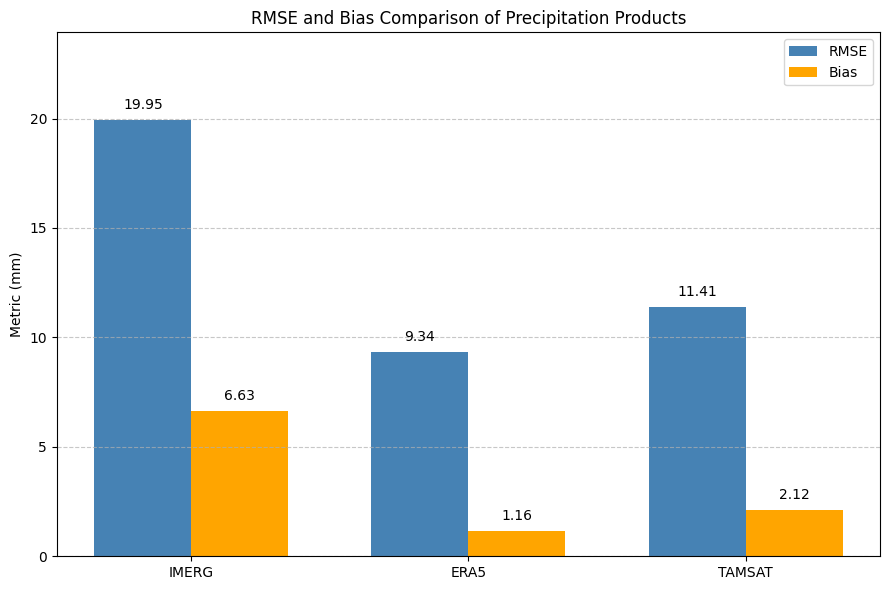

In [38]:
# @title Step 11: Visualise the products performance

products = ['IMERG', 'ERA5', 'TAMSAT']

# Example metrics — replace with your computed values
rmse_values = [imerg_rmse, era5_rmse, tamsat_rmse]
bias_values = [imerg_bias, era5_bias, tamsat_bias]

x = np.arange(len(products))  # bar positions
width = 0.35                  # width of each bar

plt.figure(figsize=(9, 6))

# RMSE bars
plt.bar(x - width/2, rmse_values, width, label='RMSE', color='steelblue')

# Bias bars
plt.bar(x + width/2, bias_values, width, label='Bias', color='orange')

# Labels and styling
plt.xticks(x, products)
plt.ylabel('Metric (mm)')
plt.title('RMSE and Bias Comparison of Precipitation Products')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Add text labels on bars
for i, v in enumerate(rmse_values):
    plt.text(i - width/2, v + 0.5, f"{v:.2f}", ha='center')
for i, v in enumerate(bias_values):
    plt.text(i + width/2, v + 0.5, f"{v:.2f}", ha='center')

plt.ylim(0, max(max(rmse_values), max(bias_values)) * 1.2)
plt.tight_layout()
plt.show()
